In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import holidays
from tqdm.notebook import tqdm

# 1.0 Import Data

In [3]:
# Import ridership data
data_dir = '/content/drive/My Drive/MIE498 Thesis/0_Data'
merged_bike_data_2019 = pd.read_csv("{}/ridership_2019_with_bike_stations_info_20200930.csv".format(data_dir), header=0)
print(merged_bike_data_2019.shape)
merged_bike_data_2019['End Day of Year'] = merged_bike_data_2019.apply(lambda row: datetime.strptime(row['End Time'], "%Y-%m-%d %H:%M:%S").timetuple().tm_yday, axis=1)
print(merged_bike_data_2019.shape)
merged_bike_data_2019.head()

(2438720, 26)
(2438720, 27)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id,Start Year,Start Month,Start Hour,Start Day of Week,Start Holiday,End Year,End Month,End Hour,End Day of Week,End Holiday,Start Day of Year,Start Week of Year,Start Lat,Start Lon,End Lat,End Lon,End Day of Year
0,4581278.0,1547.0,7021.0,2019-01-01 00:08:00,Bay St / Albert St,7233.0,2019-01-01 00:33:00,King / Cowan Ave - SMART,Annual Member,1296.0,2019.0,1.0,0.0,1.0,1.0,2019.0,1.0,0.0,1.0,1.0,1.0,1.0,43.653264,-79.382458,43.637922,-79.431734,1
1,4586979.0,1243.0,7021.0,2019-01-03 17:13:00,Bay St / Albert St,7233.0,2019-01-03 17:34:00,King / Cowan Ave - SMART,Annual Member,3168.0,2019.0,1.0,17.0,3.0,0.0,2019.0,1.0,17.0,3.0,0.0,3.0,1.0,43.653264,-79.382458,43.637922,-79.431734,3
2,4591641.0,1112.0,7021.0,2019-01-04 21:42:00,Bay St / Albert St,7233.0,2019-01-04 22:00:00,King / Cowan Ave - SMART,Annual Member,3512.0,2019.0,1.0,21.0,4.0,0.0,2019.0,1.0,22.0,4.0,0.0,4.0,1.0,43.653264,-79.382458,43.637922,-79.431734,4
3,4594328.0,1156.0,7021.0,2019-01-05 23:21:00,Bay St / Albert St,7233.0,2019-01-05 23:40:00,King / Cowan Ave - SMART,Annual Member,212.0,2019.0,1.0,23.0,5.0,0.0,2019.0,1.0,23.0,5.0,0.0,5.0,1.0,43.653264,-79.382458,43.637922,-79.431734,5
4,4596322.0,1068.0,7021.0,2019-01-06 21:42:00,Bay St / Albert St,7233.0,2019-01-06 22:00:00,King / Cowan Ave - SMART,Annual Member,3279.0,2019.0,1.0,21.0,6.0,0.0,2019.0,1.0,22.0,6.0,0.0,6.0,1.0,43.653264,-79.382458,43.637922,-79.431734,6


In [4]:
# Read station-neighbourhood mapping
df_station_assignments = pd.read_csv("{}/station_assignment.csv".format(data_dir), header=0, encoding='ISO-8859-1')
print(df_station_assignments.shape)
print(df_station_assignments.columns)
df_station_assignments.head()

(464, 7)
Index(['station_id', 'station_na', 'lat', 'lon', 'neighborhood_id', 'FSA_code',
       'da_id'],
      dtype='object')


,station_id,station_na,lat,lon,neighborhood_id,FSA_code,da_id
0,7021,Bay St / Albert St,43.653264,-79.382458,76,M5G,35204616.0
1,7160,King St W / Tecumseth St,43.643333,-79.405556,82,M5V,35204142.0
2,7012,Elizabeth St / Edward St (Bus Terminal),43.656026,-79.385327,76,M5G,35204607.0
3,7041,Edward St / Yonge St,43.656729,-79.382736,76,M5G,35204608.0
4,7275,Queen St W / James St,43.652276,-79.380701,76,M5G,35204616.0


In [5]:
station_fsa_dict = pd.Series(df_station_assignments['FSA_code'].values, index=df_station_assignments['station_id']).to_dict()
merged_data = merged_bike_data_2019.copy()
merged_data['Start Forward_Sortation_Area'] = merged_bike_data_2019.apply(lambda row: station_fsa_dict[int(row['Start Station Id'])], axis=1)
merged_data['End Forward_Sortation_Area'] = merged_bike_data_2019.apply(lambda row: station_fsa_dict[int(row['End Station Id'])], axis=1)

In [6]:
print(merged_data.shape)
merged_data.head()

(2438720, 29)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id,Start Year,Start Month,Start Hour,Start Day of Week,Start Holiday,End Year,End Month,End Hour,End Day of Week,End Holiday,Start Day of Year,Start Week of Year,Start Lat,Start Lon,End Lat,End Lon,End Day of Year,Start Forward_Sortation_Area,End Forward_Sortation_Area
0,4581278.0,1547.0,7021.0,2019-01-01 00:08:00,Bay St / Albert St,7233.0,2019-01-01 00:33:00,King / Cowan Ave - SMART,Annual Member,1296.0,2019.0,1.0,0.0,1.0,1.0,2019.0,1.0,0.0,1.0,1.0,1.0,1.0,43.653264,-79.382458,43.637922,-79.431734,1,M5G,M6K
1,4586979.0,1243.0,7021.0,2019-01-03 17:13:00,Bay St / Albert St,7233.0,2019-01-03 17:34:00,King / Cowan Ave - SMART,Annual Member,3168.0,2019.0,1.0,17.0,3.0,0.0,2019.0,1.0,17.0,3.0,0.0,3.0,1.0,43.653264,-79.382458,43.637922,-79.431734,3,M5G,M6K
2,4591641.0,1112.0,7021.0,2019-01-04 21:42:00,Bay St / Albert St,7233.0,2019-01-04 22:00:00,King / Cowan Ave - SMART,Annual Member,3512.0,2019.0,1.0,21.0,4.0,0.0,2019.0,1.0,22.0,4.0,0.0,4.0,1.0,43.653264,-79.382458,43.637922,-79.431734,4,M5G,M6K
3,4594328.0,1156.0,7021.0,2019-01-05 23:21:00,Bay St / Albert St,7233.0,2019-01-05 23:40:00,King / Cowan Ave - SMART,Annual Member,212.0,2019.0,1.0,23.0,5.0,0.0,2019.0,1.0,23.0,5.0,0.0,5.0,1.0,43.653264,-79.382458,43.637922,-79.431734,5,M5G,M6K
4,4596322.0,1068.0,7021.0,2019-01-06 21:42:00,Bay St / Albert St,7233.0,2019-01-06 22:00:00,King / Cowan Ave - SMART,Annual Member,3279.0,2019.0,1.0,21.0,6.0,0.0,2019.0,1.0,22.0,6.0,0.0,6.0,1.0,43.653264,-79.382458,43.637922,-79.431734,6,M5G,M6K


In [7]:
merged_data.isnull().sum()

Trip Id                         0
Trip Duration                   0
Start Station Id                0
Start Time                      0
Start Station Name              0
End Station Id                  0
End Time                        0
End Station Name                0
User Type                       0
Bike Id                         0
Start Year                      0
Start Month                     0
Start Hour                      0
Start Day of Week               0
Start Holiday                   0
End Year                        0
End Month                       0
End Hour                        0
End Day of Week                 0
End Holiday                     0
Start Day of Year               0
Start Week of Year              0
Start Lat                       0
Start Lon                       0
End Lat                         0
End Lon                         0
End Day of Year                 0
Start Forward_Sortation_Area    0
End Forward_Sortation_Area      0
dtype: int64

# 2.0 Bipartite Clustering Algorithm Implementation

In [8]:
print('Number of postal codes:', len(np.unique(merged_data['Start Forward_Sortation_Area'])))
print('Number of stations:', len(np.unique(merged_data['Start Station Id'])))

Number of postal codes: 38
Number of stations: 464


In [9]:
# Training: Months 1-9, Testing: Months 10-12
training_data = merged_data.loc[(merged_data['Start Month'] >= 1) & (merged_data['Start Month'] <= 9)]
testing_data = merged_data.loc[(merged_data['Start Month'] >= 10) & (merged_data['Start Month'] <= 12)]

In [10]:
print(merged_data.shape, training_data.shape, testing_data.shape)

(2438720, 29) (1970776, 29) (467944, 29)


In [11]:
merged_data.columns

Index(['Trip Id', 'Trip Duration', 'Start Station Id', 'Start Time',
       'Start Station Name', 'End Station Id', 'End Time', 'End Station Name',
       'User Type', 'Bike Id', 'Start Year', 'Start Month', 'Start Hour',
       'Start Day of Week', 'Start Holiday', 'End Year', 'End Month',
       'End Hour', 'End Day of Week', 'End Holiday', 'Start Day of Year',
       'Start Week of Year', 'Start Lat', 'Start Lon', 'End Lat', 'End Lon',
       'End Day of Year', 'Start Forward_Sortation_Area',
       'End Forward_Sortation_Area'],
      dtype='object')

## 2.1 Function Definitions

### 2.1.1 Plot Clusters and Points

In [12]:
def plot_clusters():
  fig = plt.figure(figsize=(7,7))  
  # Plot points in the clusters
  _cluster = list(df_station_assignments.groupby('cluster').groups.values())
  for c in _cluster:
    plt.scatter(df_station_assignments.loc[c]['lon'], df_station_assignments.loc[c]['lat'])
  plt.show()

### 2.1.2 Calculate Time Slot and Probabilities of Start Station checking into Cluster j

In [13]:
def calc_slot(raw_date_str):
  dt = datetime.strptime(raw_date_str, '%Y-%m-%d %H:%M:%S') #2019-01-01 00:08:00
  weekday = dt.weekday()
  hr = dt.hour

  holidays_can_on = list(holidays.CA(years=2019, prov='ON').keys())
  holiday = check_holidays(dt, holidays_can_on)
  
  # Weekdays
  if weekday <= 4 and holiday == 0:
      if hr >= 7:
        if hr <= 10:
          return 0 # Weekday Morning
        if hr <= 14:
          return 1 # Weekday Day Hours
        if hr <= 19:
          return 2 # Weekday Evening
      return 3 # Weekday Night Hours
  
  # Weekend/Holidays
  elif weekday >= 5 or holiday == 1:
    if hr >= 7:
      if hr <= 10:
        return 4 # Weekend/Holidays Morning
      if hr <= 14:
        return 5 # Weekend/Holidayss Day Hours
      if hr <= 19:
        return 6 # Weekend/Holidays Evening
    return 7 # Weekend/Holidays Night Hours

In [14]:
def check_holidays(date, holidays_can_on):
  if date in holidays_can_on: 
    return 1
  else: 
    return 0

### 2.1.3 Check if the clusters converge

In [140]:
# From github
# def checkSameCluster(s, s0):
#   A = sorted(s.groupby('cluster').groups.values(), key = lambda x: x[0])
#   B = sorted(s0.groupby('cluster').groups.values(), key = lambda x: x[0])
#   # Check if the length of A and B match (# of clusters in scope)
#   if len(A) != len(B):
#       return False
#   # For each cluster within A and B, check if the number of stations in each cluster
#   for a, b in zip(A, B):
#     # If number of stations in cluster i don't match, then return False
#     if len(a) != len(b):
#         return False
#     # If the sum of difference in row indices don't equal to zero, then return False
#     if (a != b).sum() != 0:
#         return False
  
#   # Return True if all checks passed
#   return True


def checkSameCluster(s, s0):
  station_ids_list = list(s['station_id'].unique())
  nStations = len(station_ids_list)
  df = pd.DataFrame(np.zeros((nStations, nStations))).astype(int)
  df.columns = station_ids_list
  df.index = station_ids_list
  for station in station_ids_list:
    cluster_a = int(s[s['station_id'] == station]['cluster'])
    cluster_b = int(s0[s0['station_id'] == station]['cluster'])
    if cluster_a == cluster_b:
      df.at[station, station] = 1
  print(df)
  df2 = pd.DataFrame(np.eye(nStations, dtype=int))
  similarity_score = np.multiply(df, df2).sum().sum()
  print(np.multiply(df, df2))

  if similarity_score == nStations:
    return True 
  else:
    print(nStations, similarity_score)
    return False
'''
Use a matrix to check similarities between two solutions
rows: stations in A
columns: stations in B
- If station i in A and station j in B belong to the same cluster, assign 1
- Then do elementwise multiplication, the higher the score, the more similar the two matrices are
'''

'\nUse a matrix to check similarities between two solutions\nrows: stations in A\ncolumns: stations in B\n- If station i in A and station j in B belong to the same cluster, assign 1\n- Then do elementwise multiplication, the higher the score, the more similar the two matrices are\n'

* Next steps: read the 3 papers
    * Think about motivation of each paper + how they implemented their algorithms + how do they measure the quality of solution

## 2.2 Main Bipartite Clustering Algorithm Function

In [141]:
def bipartite_clustering(ridership_data, station_data, K2, W):
  n = len(station_data)
  K1 = len(np.unique(station_data['FSA_code']))  # Number of FSAs
  
  # Initial K-Means Clustering - based on station's geographical locations
  X = np.array(station_data[['lat', 'lon']])
  print(X.shape)
  station_data['cluster'] = KMeans(n_clusters=K1).fit(X).labels_

  # Initialize iteration
  w = 0
  
  def get_t_vector(station_id):
      # Retrieve the dataframe with the selected start station 
      df_station = df_bc[df_bc['Start Station Id'] == station_id]
      # Specify the row in which the trip belongs to (based on start time)
      df_station['Time Slot'] =  df_station['Start Time'].map(calc_slot)
      # Group by the 8 time slots (8 rows in transition matrix), save in a dictionary
      timeslot_to_stationids = dict(df_station.groupby('Time Slot').groups)  # key=slot : value=row indices

      for key in timeslot_to_stationids.keys():
        # Compute number of rows in each cluster and save in a dictionary (key=cluster# : value=#ofrows)
        ndict = dict(df_station.loc[timeslot_to_stationids[key]].groupby('cluster').size())
        # Get the list of number of rows counts, saved in np.array
        count = np.array(list(map(lambda x: ndict[x] if x in ndict else 0, range(K1))))
        # Calculate the probabilities
        count = count / count.sum()
        # Update the dictionary
        timeslot_to_stationids[key] = count
      
      # If the data doesn't contain information for all time slots
      if len(timeslot_to_stationids) < 8:
        # Compute the mean values of each column in the updated timeslot_to_stationids
        mean = np.array(list(timeslot_to_stationids.values())).mean(axis=0)
        # Fill in the missing row with mean column values
        for i in range(8):
            if i not in timeslot_to_stationids.keys():
                timeslot_to_stationids[i] = mean
      
      # Return a 1D vector of probabilities of all clusters (8 rows x 38 clusters)
      return np.array(list(timeslot_to_stationids.values())).reshape(8*K1)

  # While loop
  while (w < W):
    # Merge ridership and stations datasets
    df_bc = ridership_data[['Start Time', 'Start Station Id', 'End Station Id']]
    df_bc = df_bc.merge(station_data[['station_id', 'cluster']], how='left', left_on='End Station Id', right_on='station_id').drop('station_id', axis=1)
    df_bc['Start Station Id'] = df_bc['Start Station Id'].astype("int64")
    df_bc['End Station Id'] = df_bc['End Station Id'].astype("int64")

    last_iter_station_data = station_data[['station_id', 'cluster']]

    # for i in range(n), generate t-matrix A_i (stored as t-vector; 1 feature)
    pd.options.mode.chained_assignment = None  # default='warn'
    station_ids_list = tqdm(df_station_assignments['station_id'])
    X = np.array(list(map(get_t_vector, station_ids_list)))  # Shape: (464, 304); 464 stations, 8*K1=304
    print(X.shape)
    # Cluster stations in to K2 clusters based on t-matrices
    station_data['cluster'] = KMeans(n_clusters=K2).fit(X).labels_
    vals = station_data.groupby('cluster').groups.values() # row indices for each K2 cluster
    offset = 0
    for v in vals:
      # Get the lat and lon of stations
      X = np.array(station_data.loc[v][['lat', 'lon']])
      # Cluster stations in C_2j into [Nj*K1/n] groups
      Nj = len(v) # Number of stations in cluster j
      n_c = int(np.round(Nj*K1/n))
      station_data.loc[v,'cluster'] = KMeans(n_clusters=n_c).fit(X).labels_ + offset
      offset += n_c
    plot_clusters()
    if checkSameCluster(station_data, last_iter_station_data):
        break
    w += 1

  K1 = offset # offset might be K1 + 1 because of rounding error
  
  return station_data

(464, 2)


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


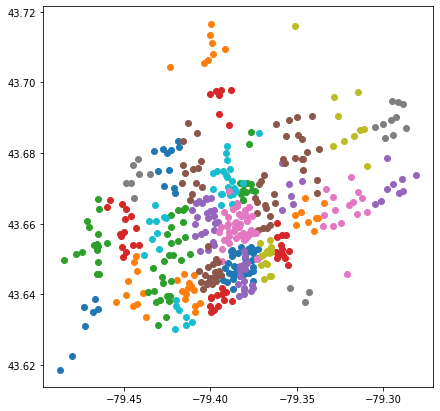

      7021  7160  7012  7041  7275  7199  ...  7447  7504  7486  7482  7448  7395
7021     0     0     0     0     0     0  ...     0     0     0     0     0     0
7160     0     0     0     0     0     0  ...     0     0     0     0     0     0
7012     0     0     0     0     0     0  ...     0     0     0     0     0     0
7041     0     0     0     0     0     0  ...     0     0     0     0     0     0
7275     0     0     0     0     0     0  ...     0     0     0     0     0     0
...    ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
7504     0     0     0     0     0     0  ...     0     0     0     0     0     0
7486     0     0     0     0     0     0  ...     0     0     0     0     0     0
7482     0     0     0     0     0     0  ...     0     0     0     0     0     0
7448     0     0     0     0     0     0  ...     0     0     0     0     0     0
7395     0     0     0     0     0     0  ...     0     0     0     0     0     0

[464 rows x 464

In [142]:
station_data_w_clusters = bipartite_clustering(ridership_data=merged_data, station_data=df_station_assignments, K2=5, W=1)

In [143]:
station_data_w_clusters

,station_id,station_na,lat,lon,neighborhood_id,FSA_code,da_id,cluster
0,7021,Bay St / Albert St,43.653264,-79.382458,76,M5G,35204616.0,0
1,7160,King St W / Tecumseth St,43.643333,-79.405556,82,M5V,35204142.0,35
2,7012,Elizabeth St / Edward St (Bus Terminal),43.656026,-79.385327,76,M5G,35204607.0,16
3,7041,Edward St / Yonge St,43.656729,-79.382736,76,M5G,35204608.0,16
4,7275,Queen St W / James St,43.652276,-79.380701,76,M5G,35204616.0,34
...,...,...,...,...,...,...,...,...
459,7504,Gerrard St E / Victoria Park Ave - SMART,43.686962,-79.286864,62,M4E,35200654.0,27
460,7486,Gerrard St E / Ted Reeve Dr,43.684261,-79.299332,62,M4E,35200654.0,27
461,7482,Danforth Ave / Sibley Ave - SMART,43.690111,-79.292634,61,M4C,35200643.0,27
462,7448,Goodwood Park Ct / Dentonia Park - SMART,43.694826,-79.295208,61,M4C,35204372.0,27


In [145]:
station_data_w_clusters.to_csv('/content/drive/My Drive/MIE498 Thesis/Share-Bike-Station-Clustering-and-Usage-Prediction/station_data_w_clusters.csv')

In [ ]:
# Error matrix
# Test different W values

### Training Steps
1. **Regroup**
    * Regroup bike stations into clusters
2. **Predict**
    * Predict bike demands for each cluster
3. **Summary Statistic - 1 transition matrix**
    * Use normalized counts (counts / total counts) as transition probabilities from one cluster to another cluster

### Model Evaluation
1. **Error matrix**
    * Have an error matrix for each day (transition matrix each day - summary transition matrix)
    * Then consolidate into one summary error matrix <-- minimize this during training

### Testing
1. Regroup, predict, summary statistic --> using parameters obtained from training for the algorithms?
2. Evaluate the model's error on testing data

# Not Used

## Initial K-Means Clustering

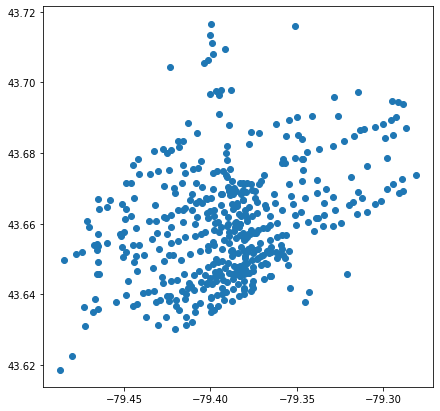

In [ ]:
'''
K1 = len(np.unique(df_station_assignments['FSA_code']))  # Number of FSAs
X = df_station_assignments[['lat', 'lon']]
plt.figure(figsize=(7,7))
plt.scatter(X['lon'], X['lat'])

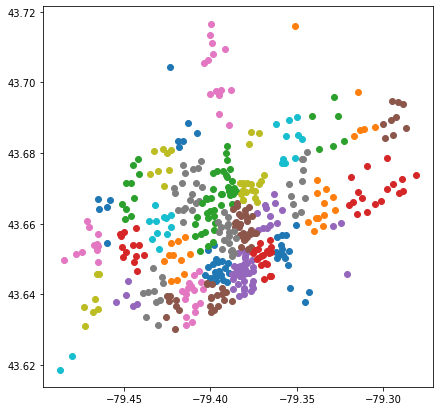

In [ ]:
'''
kmeans = KMeans(n_clusters=K1, random_state=0).fit(X)
plot_clusters()
df_station_assignments['cluster'] = kmeans.labels_
initial_station_to_cluster = dict(zip(df_station_assignments['station_id'], kmeans.labels_))

In [ ]:
'''
df_bc = merged_data[['Start Time', 'Start Station Id', 'End Station Id']]
df_bc = df_bc.merge(df_station_assignments[['station_id', 'cluster']], how='left', left_on='End Station Id', right_on='station_id').drop('station_id', axis=1)
df_bc.head()

,Start Time,Start Station Id,End Station Id,cluster
0,2019-01-01 00:08:00,7021.0,7233.0,17
1,2019-01-03 17:13:00,7021.0,7233.0,17
2,2019-01-04 21:42:00,7021.0,7233.0,17
3,2019-01-05 23:21:00,7021.0,7233.0,17
4,2019-01-06 21:42:00,7021.0,7233.0,17


## While Loop

In [ ]:
'''
pd.options.mode.chained_assignment = None  # default='warn'
station_ids_list = tqdm(df_station_assignments['station_id'])
X = np.array(list(map(get_t_vector, station_ids_list)))  # Shape: (464, 304); 464 stations, 8*K1=304

  0%|          | 0/464 [00:00<?, ?it/s]

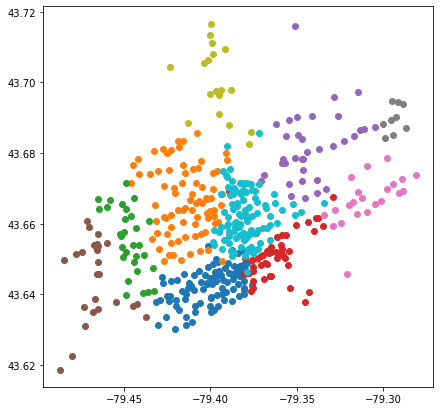

In [ ]:
'''
K2 = 10
kmeans = KMeans(n_clusters=K2).fit(X)
df_station_assignments['cluster'] = kmeans.labels_
plot_clusters()

In [ ]:
'''
n = len(df_station_assignments)
vals = df_station_assignments.groupby('cluster').groups.values()  # row indices
offset = 0
for v in vals:
  # Get the lat and lon of stations
  X = np.array(df_station_assignments.loc[v][['lat', 'lon']])
  Nj = len(v) # Number of stations in cluster j
  n_c = int(np.round(Nj*K1/n))
  df_station_assignments.loc[v,'cluster'] = KMeans(n_clusters=n_c).fit(X).labels_ + offset
  offset += n_c

print('BC (first iteration, not convergent yet)')
plot_clusters()

## Other

In [ ]:
'''
# Split data into 464 dataframes, one for each station
def split_dataframe(data):
  # Get the list of unique FSAs
  unique_start_station = list(np.unique(data['Start Station Id']))

  df_station_list = []
  for station in unique_start_station:
    df_temp = data[data['Start Station Id'] == station]
    df_temp.set_index('Trip Id', inplace=True)
    df_station_list.append(df_temp)

  return unique_start_station, df_station_list

In [ ]:
'''
# Given all station data, and the dataframe of the station of interest, K1 (number of FSAs)
def create_transition_matrix(data_all, df, K1):
  # Get the list of unique Start FSAs
  unique_start = list(np.unique(data_all['Start Forward_Sortation_Area']))

  # Create an empty dataframe for transition matrix to return
  df_transition = pd.DataFrame(data=np.zeros((K1, K1)), columns=unique_start, index=unique_start)
  df_transition = df_transition.astype("int")

  # Get number of days in the given dataframe 
  num_days = len(np.unique(df['Start Day of Year']))

  # Iterate through each Start FSA (filling in row by row)
  for start_fsa in unique_start:
    # For each Start FSA dataframe, count number of trips in each End FSA, rename the column
    df_temp = df[df['Start Forward_Sortation_Area'] == start_fsa]
    df_temp = pd.DataFrame(df_temp['End Forward_Sortation_Area'].value_counts())
    # Rename the column name and compute the average daily number of trips that ended in the End FSA
    df_temp.rename(columns={'End Forward_Sortation_Area': 'Average Daily Number of Trips'}, inplace=True)
    df_temp['Average Daily Number of Trips'] = df_temp['Average Daily Number of Trips'].div(num_days).round(3)

    # Get the unique list of End FSAs in the trip counts dataframe
    end_fsa_list = list(df_temp.index)
    
    # Iterate through each End FSA
    for end_fsa in end_fsa_list:
      # Locate the End FSA value in the dataframe and fill in the transition matrix
      cnt = df_temp.loc[end_fsa]['Average Number of Trips']
      df_transition.loc[start_n, end_fsa] = cnt

  return df_transition

In [ ]:
'''
# Given all station data, K1 (number of FSAs)
def generate_t_matrix(data_all, K1):
  # Create a separate df for each start station
  unique_start_station, df_station_list = split_dataframe(data_all)

  # Compute the transition matrices, one for each station
  df_transition_list = []
  for i, df_station in enumerate(df_station_list):
    if i % 10 == 0:
      print(f'{i} stations processed...')
    df_transition_temp = create_transition_matrix(data_all, df_station, K1)
    df_transition_list.append(df_transition_temp)
  
  return unique_start_station, df_transition_list